Functions that are not differentiable;

* unknown fn
* stochastic (can differentiate, but might not give sensible answers?)
* discrete (and categorical) (ints, ...)
* dynamic (closely related to discrete? this is more of a problem from propagation? can still estimate gradient, just can back prop them where we want? as no dependency exists?)
* various dtypes, trees, graphs, ...

Kinda/Partially differentiable

* Its too big/dont have access
* 

Ultimate goal? 
- AD that can be efficiently used on all types of fn.
- Also gives access to arbitrary higher order derivatives?
- Can easily trade off;
    - accuracy for computational efficiency.
    - time for memory.
    - ?

Intro/background;

* control variates
* reparameterisation trick
* score function and surrogate losses
* cts relaxations
* ?



In [126]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import networkx as nx

# Sotchastic

Why does stochasticity mean we cant take the derivative?
Let $\bar x$ be some random variable, and let $\bar y = f(\bar x)$. So, we want $\frac{d\bar y}{d\bar x}$. 


Dont know if $\Delta y$ is due to $\Delta \theta$ or noise produced by $\bar x$. _It is a credit assignment problem?_
If we have multiple RVs then what is the likelihood one of them produced $\Delta y$ versus the likelihood of our pertubation of $\theta$?

1.0223661450054902


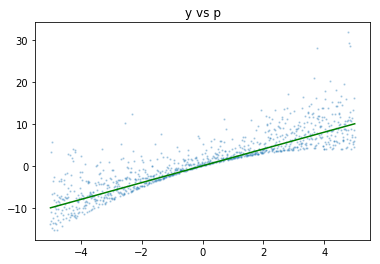

In [7]:
N = 1000
gaussian = lambda mean, stddev, N: rnd.standard_normal(N)*stddev + mean

p = np.linspace(-5, 5, N)
def fn(p):
    x = gaussian(0, 1, len(p))
    return x**2 + 2*p + x*p  # multiplicaive noise really fs things up...
y = fn(p)

# dydp = np.mean(2*x+p)   # take derivative and then marginalise
# must marginalise out the noise
# marginalisation works here because x is unbiased around 0
# print(dydp)

#####
# alternatively
E_y = np.mean(y)  # marginalise then take derivative
dydp = p
print(E_y)

plt.scatter(p, y, alpha=0.25, s=1.5)
plt.plot(p, 2*p, c='g')
_ = plt.title('y vs p')

(-10, 40)

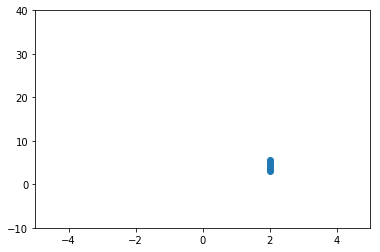

In [8]:
# ok, dydp seems clear, but what if we have fewer samples
n_samples = 5
p_val = 2
p = np.array([p_val]*n_samples)  # take n_samples at p=p_val
plt.scatter(p, fn(p))
plt.plot(p, 2*p, c='g', alpha=0.1)
plt.xlim(-5, 5)
plt.ylim(-10, 40)
# what is dydp?

# actually tbh, you still get a pretty decent estimate with
# few samples. what if we turn the variance up?

In [9]:
# what if the noise is biased!?

#### Variance reduction
What is necessary to estimate a graident?
__Why do we care about variance reduction? If the estimate is accurate, what does it matter?__


A motivating example??? Show that optimisation with high variance is slower!?

In [11]:
def estimate(x):
    # cumlative mean
    return [np.mean(x[:i]) for i in range(1,N)]  # could be done recursively.

m_1 = estimate(gaussian(0, 1, N))
m_3 = estimate(gaussian(0, 4, N))
m_5 = estimate(gaussian(0, 8, N))

Text(0,0.5,'Estimated mean')

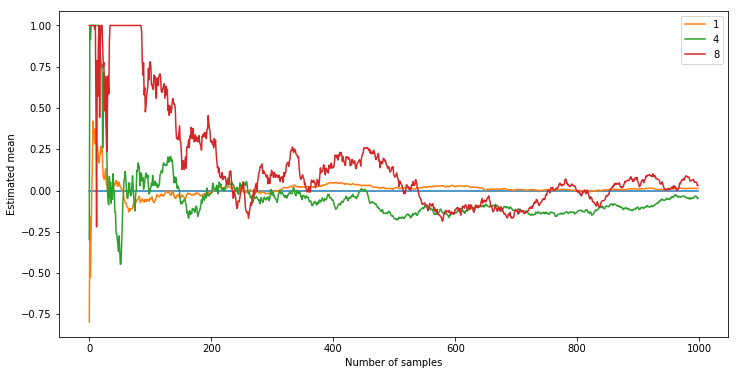

In [12]:
plt.figure(figsize=(12,6))
plt.plot(np.zeros(len(m_1)))
plt.plot(np.clip(m_1, -1, 1), label='1')
plt.plot(np.clip(m_3, -1, 1), label='4')
plt.plot(np.clip(m_5, -1, 1), label='8')
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Estimated mean')

Ok, so the mean tends to wander around more if there is more variance. So there must be a bound on the accuracy of the mean, given the variance!? 

$$
\epsilon = \mathbb E[x] - \frac{1}{N}\sum_{i=0}^N x \\
\epsilon = \mathcal O(\sigma)
$$

Still doesnt tell me why high variance matters... It matterns in the context of optimisation because !??!??

Need some unbiased estimator? But now the framework wont be functional anymore? As we need states to remember things, so we can calculate a mean field? Or we just do a large amount of expensive MC simulations?

__Dependencies; reparameterisation-trick, gumbel-trick and REINFORCE?__

## Control variates


* https://en.wikipedia.org/wiki/Control_variates
* Control Variates By Christiane Lemieux

> In order to reduce the variance $\sigma^2/n$, two approaches are possible. One is to replace the function $\hat h$ by an alternative function $\hat h$ such that $E( h(X))= μ$ but with $Var( h(X))
< σ^2$. This is the idea behind variance reduction techniques. The second approach consists of replacing the iid sampling scheme at the basis of Monte Carlo simulation by quasi-random sampling (see Random Number Generation and Quasi-Monte Carlo), thereby changing the $1/n$ convergence rate of the variance by possibly something as fast as $\mathcal O((log n)^d/n^3 )$, where d is the dimension of the problem. The method of control variates that we are
about to describe falls in the first category of approaches.

?

> First, we must find a random variable W such that μ w = E(W ) can be computed analytically and also such that Y and W are dependent.

?

> To see why this is useful, consider the case where
Y and W are positively correlated. Then if the naive estimator μ ̂ w,n is lower than its expected value of μ w ,
it suggests that probably μ ̂ n is also lower than the unknown μ, and therefore, a positive correction should
be added to it to reduce its error.

?

> As the goal of this technique is to get an estimator with smaller
variance than the naive Monte Carlo estimator, it makes sense to try to choose β so as to minimize the
variance of μ ̂ cv,n .

__Q__; Is tha really true? Sure we dont want to pick b to minimise the variance of the target fn?



__Q__; What about memory limited settings. When you cannot keep thousands of past 

In [13]:
n_samples = 2000

def F(x):
    return 1/(1+x)

samples = rnd.random(n_samples)
f = F(samples)

print(np.mean(f), np.var(f))

0.6930563360275407 0.019946565766961216


In [14]:
mean_g = 3/2  

def G(x):  
    # why this fn!?  
    # can different fns give better results?
    # why sorts of fns give better results? and why?
    # what if g is biased? biased to what alex... 
    # the whole point was that we chose a G that wasnt...
    return x + 1

g = G(samples)

c = -np.var(f)/np.cov(f,g)[0,1]  # want to derive this myself
# print(c)

output = f + c*(g - mean_g)  
# does this introduce any bias?
# seems like it should, why doesnt it?
# could try prove it? E[f] = E[f + c(g-mu_g)]

print('Mean: {}'.format(np.mean(output)), 
      '\nVariance: {}'.format(np.var(output)), 
      '\n{:.3f} times variance reduction'.format(np.var(f)/np.var(output))
     )

Mean: 0.6938519410220364 
Variance: 0.0006450285213538821 
30.924 times variance reduction


In [15]:
# ok, lets see f I am starting to understand.
# so if the control fn is more similar to
# the target fn then we should get more variance reduction?

mean_h = 0.4054  # found using samples
def H(x):  
    return  1/(x + 2)
h = H(samples)

c = -np.var(f)/np.cov(f,h)[0,1] 
output = f + c*(h - mean_h)  

print('Mean: {}'.format(np.mean(output)), 
      '\nVariance: {}'.format(np.var(output)), 
      '\n{:.3f} times variance reduction'.format(np.var(f)/np.var(output))
     )

Mean: 0.6932127454681816 
Variance: 0.00011105091895410239 
179.616 times variance reduction


Multiple control varaties. 

In the example above, we are kinda saying, assume F is similar to G. If our sample is from G is a distance from its mean then the sample is also a similar distance from F's mean.
When F isnt like G, this will be wrong, but not a big deal as that is what we used their correlation for. 

_What if we made $c$ a fn of the position of the sample? c(x)? Rather than a single linear approximation of the similarity between F and G we could tune it locally. 

Generalising this to many controls. Constraining F to be within G_i. If sample is greater than G_1, and G_2 but less than G_3 then assume the sample was slightly too high and correct it. (but what if we had extra/partial info that G_3 was very similar to F? -- this is what c is trying to correct for?!)

## Reparameterisation

...

## Score functions

$$
x \sim p(x|\theta) \\
\nabla_{\theta} \mathbb E_x[f(x)] = \mathbb E_x [f(x)\nabla_{\theta} \log p(x | \theta)]
$$

How is this anything special? It is just chain rule?!

Where does p(x|\theta) come from? How is it calculated/estimated?

$$

$$

#### Reinforce

> This estimator is unbiased, but in general has high variance. Intuitively, this estimator is limited by the fact that it doesn’t use any information about how $f$
depends on $b$, only on the final outcome $f(b)$.





> If instead x is a deterministic function of θ and another random variable z, the operators∇θandEz commute, yielding the
pathwise  derivative  estimator or reparameterisation trick.
??

# Discrete

Types of variable; continuious, discrete, categorical, ?
What we really care about; Ordered? 

## Cts relaxations and soft-ness

What do we mean by soft?

* Sigmoids as a soft step fn.
* Gumbel-softmax as a soft argmax.
* ? as a soft look-up.
* ? as a 

are these general enough to cover things like mcts, sat, 

## 

* Look up -- skip gradients and regularise.
* Weighted sum rather than ?
* 

Should the cts value be used or should it be sampled?

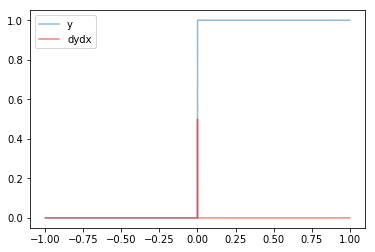

In [16]:
N = 10000
x = np.linspace(-1, 1, N)
y = (x > 0).astype(np.float32)
plt.plot(x, y, alpha=0.5, label='y')

# use finite differences to approximate as 
# the gradident of greater than isnt defined.
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()
# scale the grad so we can make sense of it

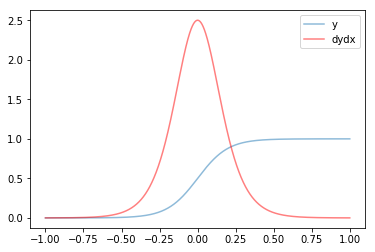

In [106]:
N = 10000
x = np.linspace(-1, 1, N)
y = 1/(1+np.exp(-10*x))
plt.plot(x, y, alpha=0.5, label='y')

# use finite differences to approximate as 
# the gradident of greater than isnt defined.
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx, c='r', alpha=0.5, label='dydx')
plt.legend()
# scale the grad so we can make sense of it

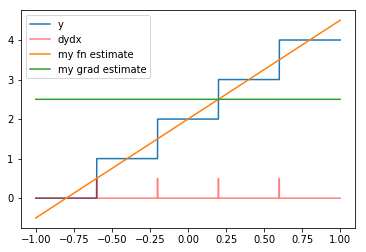

In [107]:
# what about many steps?
x = np.linspace(-1, 1, N)

def stepper(x, n):
    v = np.arange(n)
    m = len(x)//n
    return np.hstack([[v[i]]*m for i in range(n)])

n = 5
y = stepper(x, n)
plt.plot(x, y, label='y')

dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.plot(x, x*(n/2)+ n/2 - 0.5, label='my fn estimate')
plt.plot(x, np.ones_like(x)*(n/2), label='my grad estimate')
plt.legend()

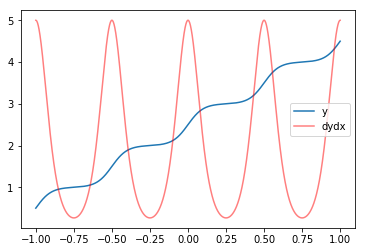

In [108]:
def soft_step(x, c, w):
    return 1/(1+np.exp(-w*(x+c)))

def soft_stepper(x, n):
    y = np.zeros_like(x)
    C = np.linspace(-1, 1, n)
    for i in range(n):
        y += soft_step(x, -C[i], 20)
    return y

y = soft_stepper(x, 5)
plt.plot(x, y, label='y')

dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx, c='r', alpha=0.5, label='dydx')
plt.legend()

# not sure how helpful that is...
# hmm. all grad values are greater than zero,
# so if we were trying to do grad ascent then
# they should lead us in the right direction.

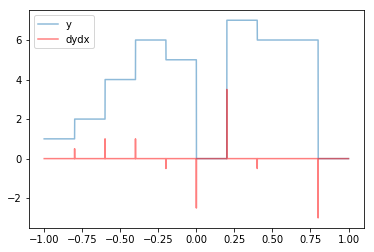

In [109]:
# what about categorical variables?
def categorical(x, n):
    y = np.zeros_like(x)
    m = len(x)//n
    for i in range(n):
        # what if n is correlated with x
        y[m*i:m*(i+1)] = rnd.randint(0, n)
    return y

y = categorical(x, 10)
plt.plot(x, y, alpha=0.5, label='y')
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()

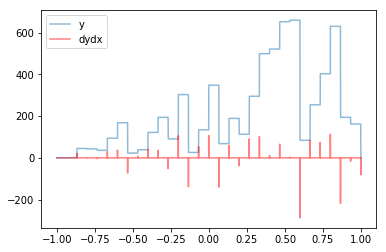

In [110]:
# what about weak ordering of dimensions?
# DEFINE weak ordering!?
# somewhere in between discrete and categorical variables
# for example, below

def categorical(x, n):
    y = np.zeros_like(x)
    m = len(x)//n
    for i in range(n):
        # what if n is correlated with x
        y[m*i:m*(i+1)] = rnd.randint(0, n*i+1)
    return y

y = categorical(x, 30)
plt.plot(x, y, alpha=0.5, label='y')
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()

# what if indices have noise? cant trust the ordering!!!
# that is the main reason stochasticity is hard!?@?!#?
# what if we were allowed to perturb the indices and do a local sort/perturb?
# assuming the noise is ?? then this could work?

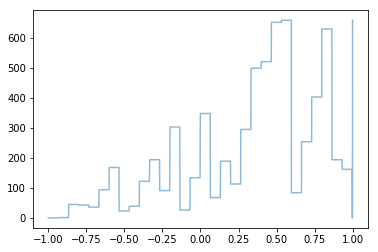

In [117]:
def sort_1_step(x, y):
    # if your 2-neighbor is more similar to you
    # than your 1-neighbor then swap
    # we are assuming x is arbitrary so we can move it around.
    a = x.copy()
    b = y.copy()
    for i in range(len(x)-1):
        if b[i] > b[i+1]: 
#             a[i:i] = list(reversed(a[i:i+2]))
            b[i:i+2] = list(reversed(b[i:i+2]))
    return a, b
            
x, y = sort_1_step(x, y)
plt.plot(x, y, alpha=0.5, label='y')
# dydx = (y[1:] - y[:-1])/(2/N)
# plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
# plt.legend()

## Locality

You can have locality in graphs, as long as you have some __metric__ to order the nodes and construct the adjacency matrix. 
So the metric is the key!?

So when we use the reals our metric is ???

In [205]:
# connectedness using neighbors?!
# label propagation of loss?
# have some underlying topology of how fns are related.
# can query loss at some nodes and propagate loss the graph?!

# what if we did this for NNs?
# calculate their distance from each other in parameter space?
# MUST be better alternatives for measuing similarity/constructing the graph
# would be expensive to keep the actual parameter, but could easily store the graph

T = rnd.standard_normal((10,1))

def loss_fn(x):  # loss is distance from T
    return np.sum(np.power(x - T, 2))

n = 20
NNs = [rnd.standard_normal((10,1)) for _ in range(n)]
distances = np.array([[np.linalg.norm(a-b) for a in NNs] for b in NNs])
distances = distances / np.linalg.norm(distances, axis=0)  # is this the right axis?
losses = [loss_fn(nn) for nn in NNs[:n//2]] # only test the first half
losses = np.array(losses + [0]*(n//2))  # we dont know the loss of the other half

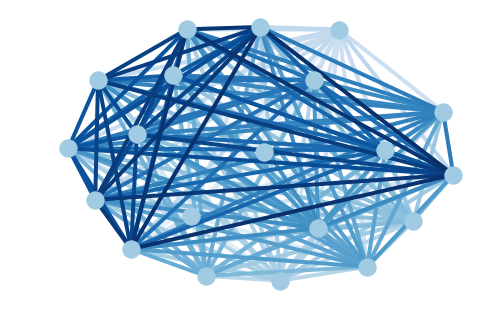

In [206]:
# m = rnd.choice([0,1], (8,8,), p=[0.7, 0.3])
g = nx.from_numpy_matrix(distances)
g = nx.convert_node_labels_to_integers(g)
colors = range(len(g.edges))
nx.draw(g,pos=nx.spring_layout(G), 
        node_color='#A0CBE2',
        edge_color=colors,
        width=4,
        edge_cmap=plt.cm.Blues,
        with_labels=False)
plt.show() # display

In [207]:
losses

array([20.2378646 , 21.95555553,  5.49127983, 13.96022894, 23.21754545,
       11.92296158, 10.38851321,  7.66327525, 17.79251064, 15.1077228 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [208]:
np.inner(distances, losses)

array([29.621753  , 28.34841681, 32.16745621, 26.40204525, 27.44440327,
       28.02007125, 35.28426973, 28.58625361, 29.7459798 , 26.60329524,
       37.53892136, 34.57792728, 37.9942555 , 30.55105338, 33.86065416,
       33.57551757, 32.81755978, 35.64412152, 37.3795428 , 28.88069098])

In [209]:
[loss_fn(nn) for nn in NNs[n//2:]] # only test the first half

[15.664269938039999,
 16.604738263119025,
 17.569332354305367,
 8.057424451951501,
 13.049781370131504,
 18.407356390007173,
 15.68041532023816,
 22.842833849934504,
 17.322598039588833,
 11.243450623823959]

In [ ]:
# what was that mallat paper where they impose an order on hiddens 
# for a conv layer?

## Rebar

Our strategy will be to construct a control variate based on the difference between the REINFORCE gradient estimator for the relaxed model and the gradient estimator from the reparameterization trick.

how does this work with mini-batches!?

What is more similar to our function that another estimate of our fnction? Where can we get an accurate estimate of the mean of our fn?


$$
\begin{align*}
\mathbb E_{p(b)} [f(b, \theta)]& && \text{Want to maximise}\\
\frac{\partial f}{\partial \theta} \mathbb E_{p (b)} [f(b, \theta)]&= \sum \big[ \frac{\partial p(b)}{\partial \theta} f(b, \theta) +  p(b) \frac{\partial f(b, \theta)}{\partial \theta} \big] && \text{do GD on 1.}\\
x &=1   && x \text{ must be one}
\end{align*}
$$

In [9]:

def rebar():
    pass


## Bprop through the void

https://github.com/wgrathwohl/BackpropThroughTheVoidRL

When $c_{\phi} = f$, then LAX becomes the reparameterization estimator for $f$.

How to find $c_{\phi}$? 

* $argmin_{\phi} (f(b) - c_{\phi}(b))^2$  (Relationship to actor-critic!? and qprop?!?)
* $argmin_{\phi} Var(\hat g)$

Seems very clear here? We are jointly learning a model of f(b)!
Are there pathogogical minima when trying to minimise variance? Seems dangerous?



***

Getting more info from stochastic gradients!
How can we measure the info in a set of feedback? Reliability/variance, first order vs 2nd order, ...?


***

* tbh, their experiments are abit dodgy? unclear if it works better than rebar.
* more accurate gradients means less noise... possibly less exploration..
* interesting problem. works ok for markov processes. but what about partial info settings. they are going to have biased estimators!?
* now we have a bunch of hyper param for $c_{\phi}$. What if it starts overfitting or diverges?
* one accurate estimators vs many less accurate ones!?
* i am a little confused as to what the contribution of this paper is... seems very incremental
* getting access to a_t created a longer dependency?
* relationship to Doubly Robust Estimation?

## Dice

* Why do we care about second order gradients?
* How did the old approaches fail?
* 

$\dicei$

Generalising AD to stochastic graphs. 

Why would we ever want to construct graphs with random variables in them? (not in them, but ?)
* Meta learning? Loss is a random variable (of the data)?
* RL?
* 

Approaches

* Surrogate objective and AD (although objective is the wrong way to view it as it is independent of loss functions)
* 

## Blackbox backpropagation with jacobian sensing
`Unknown`

> Efficient coloring of G weak int for reducing the dimensionality of the problem, where each variable in the compressed problem corresponds to a subset of variables in the original problem.

Why does this approach handle noise so well? How does it relate to RELAX?

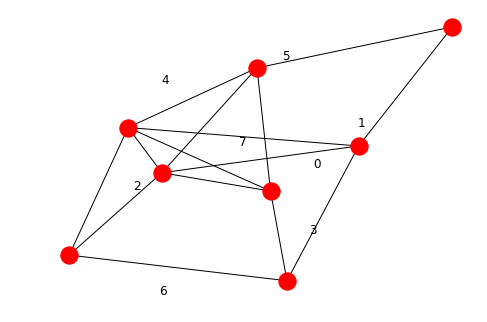

In [76]:
m = rnd.choice([0,1], (8,8,), p=[0.7, 0.3])
g = nx.from_numpy_matrix(m)
g = nx.convert_node_labels_to_integers(g)
nx.draw(g)
labels=nx.draw_networkx_labels(g, pos=nx.spring_layout(g))

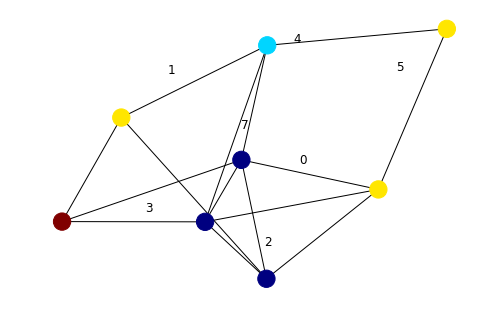

In [77]:
d = nx.coloring.greedy_color(g)
nx.draw(g, node_color=list(d.values()))
labels=nx.draw_networkx_labels(g, pos=nx.spring_layout(g))

In [71]:
d

{0: 1, 1: 1, 2: 0, 3: 1, 4: 4, 5: 2, 6: 0, 7: 3}

In [72]:
np.array(nx.adjacency_matrix(g).todense())

array([[0, 0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 1, 0],
       [1, 0, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0]], dtype=int64)


#### Goal, recover the jacobian efficiently.
* If you happen to know the graph then just do AD.
* If you can make an accurate guess about the graph, then ?? (also how would the guess be improved?)
* If you have partial information about the graph structure (sparsity structure of adjacency, then this is the solution!?)
    * What if the adjacency had probabilities of being connected, rather than abs values, 0, 1.
    * what if it has blocks?
    * symmetry?!? positive definiteness? rank? ...
* If you have partial information about the contents of the graph?
    * Edge types?
    * ?
* 

Worst case. n function calls. Which for nns, might be ~1000000...

***

If we have a nested fn, such as $y = f_{\theta}(g_{\phi}(x))$, then what does this tell us about the structure of the jacobian (and/or hessian?)? Let $\psi = [\theta; \phi]$. 
$$\frac{\partial y}{\partial \psi} =
\begin{bmatrix}
\frac{\partial y}{\partial \theta} \\
\frac{\partial y}{\partial z}\frac{\partial z}{\partial \phi} \\
\end{bmatrix}
$$

***

#### Goal, recover the graph efficiently.
* ?


In what cases must we treat our fn as a black box? RL!

Relation to causality? What if we started with the jacobian and wanted the graph?!

In the non linear case, how do you represent the jacobian? Just use some arbitrary fn approximator? Can we find an approximator suited for this problem? What is unique to the problem?

In [ ]:
# ideally code for tf? or pytorch?
# that is another project...?

def estimate_grad(f, x, prior):
    # Combinatorial Variable Compression via Graph Coloring
    assignments = color(prior)
    # Choice of Perturbation Directions
    directions = choose(assignments, ?)
    # Recovery via Compressed Convex Optimization
    